# inspect df

# Removing try catch blocks from extractor

In [19]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2
from rdkit.rdBase import BlockLogs as rdkit_BlockLogs

In [31]:
def find_smiles(
        identifiers,
    ):
        """
        Search through the identifiers to return a smiles string, if this doesn't exist, search to return the English name, and if this doesn't exist, return None
        """
        non_smiles_names_list = (
            []
        )  # we dont require information on state of this object so can create a new one
        _ = rdkit_BlockLogs()
        for i in identifiers:
            if i.type == 2:
                canon_smi = i.value
                return canon_smi, non_smiles_names_list
        for ii in identifiers:  # if there's no smiles, return the name
            if ii.type == 6:
                name = ii.value
                non_smiles_names_list.append(name)
                return name, non_smiles_names_list
        return None, non_smiles_names_list


def rxn_input_extractor(rxn):
        """
        Extract reaction information from ORD input object (ord_reaction_pb2.Reaction.inputs)
        """
        # loop through the keys (components) in the 'dict' style data struct. One key may contain multiple components/molecules.
        non_smiles_names_list = (
            []
        )  # we dont require information on state of this object so can create a new one
        # initialise lists
        reactants = []
        reagents = []
        solvents = []
        catalysts = []
        products = []

        for key in rxn.inputs:
            components = rxn.inputs[key].components
            for component in components:
                rxn_role = component.reaction_role  # rxn role
                identifiers = component.identifiers
                smiles, non_smiles_names_list_additions = find_smiles(
                    identifiers
                )
                non_smiles_names_list += non_smiles_names_list_additions
                if rxn_role == 1:  # NB: Reagents may be misclassified as reactants
                    reactants += [r for r in smiles.split(".")]
                elif rxn_role == 2:  # reagent
                    reagents += [r for r in smiles.split(".")]
                elif rxn_role == 3:  # solvent
                    solvents += [r for r in smiles.split(".")]
                elif rxn_role == 4:  # catalyst
                    catalysts += [r for r in smiles.split(".")]
                elif rxn_role in [5, 6, 7]:
                    # 5=workup, 6=internal standard, 7=authentic standard. don't care about these
                    continue
                elif rxn_role == 8:  # product
                    # there are typically no products recorded in rxn_role == 8, they're all stored in "outcomes"
                    products += [r for r in smiles.split(".")]
        return (
            reactants,
            reagents,
            solvents,
            catalysts,
            products,
            non_smiles_names_list,
        )

In [39]:
# Load Dataset message
pb = 'data/ord//02/ord_dataset-02ee2261663048188cf6d85d2cc96e3f.pb.gz'
pb = 'orderly/data/ord_test_data/00/ord_dataset-00005539a1e04c809a9a78647bea649c.pb.gz'
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

In [45]:
data.reactions[0].outcomes[0].products[0].measurements

[type: YIELD
percentage {
  value: 65.39
}
]

## First try: simply remove

## Second try: add catch for measurements = None, and remove yield if len(products_list) != 1

In [47]:
# before
for product in products_obj:
    try:
        y = None
        identifiers = product.identifiers
        (
            product_smiles,
            non_smiles_names_list_additions,
        ) = OrdExtractor.find_smiles(identifiers)

        non_smiles_names_list += non_smiles_names_list_additions
        measurements = product.measurements
        for measurement in measurements:
            if measurement.type == 3:  # YIELD
                y = float(measurement.percentage.value)
                y = round(y, 2)
        # people sometimes report a product such as '[Na+].[Na+].[O-]B1OB2OB([O-])OB(O1)O2' and then only report one yield, this is a problem...
        # We'll resolve this by moving the longest smiles string to the front of the list, then appending the yield to the front of the list, and padding with None to ensure that the lists are the same length

        # split the product string by dot and sort by descending length
        product_list = sorted(product_smiles.split("."), key=len, reverse=True)

        # create a list of the same length as product_list with y as the first value and None as the other values
        y_list = [y] + [None] * (len(product_list) - 1)

        products += product_list
        yields += y_list
    except IndexError:
        continue

TypeError: 'NoneType' object is not iterable

In [ ]:
# before
for product in products_obj:
    y = None
    identifiers = product.identifiers
    (
        product_smiles,
        non_smiles_names_list_additions,
    ) = OrdExtractor.find_smiles(identifiers)

    non_smiles_names_list += non_smiles_names_list_additions
    measurements = product.measurements
    if measurements is not None:
        for measurement in measurements:
            if measurement.type == 3:  # YIELD
                y = float(measurement.percentage.value)
                y = round(y, 2)
    # people sometimes report a product such as '[Na+].[Na+].[O-]B1OB2OB([O-])OB(O1)O2' and then only report one yield, this is a problem...
    # We'll resolve this by moving the longest smiles string to the front of the list, then appending the yield to the front of the list, and padding with None to ensure that the lists are the same length

    # split the product string by dot and sort by descending length
    #ASSUMPTION: The largest product is the one with the yield
    product_list = sorted(product_smiles.split("."), key=len, reverse=True)
    

    # create a list of the same length as product_list with y as the first value and None as the other values
    y_list = [y] + [None] * (len(product_list) - 1)

    products += product_list
    yields += y_list


In [51]:
a = [1]
a += [1,2,3]
a

[1, 1, 2, 3]

# Inspect clean df

In [6]:
import pandas as pd

df = pd.read_parquet('data/orderly/orderly_ord.parquet')

In [7]:
# Define the list of columns to check
columns_to_check = [col for col in df.columns if col.startswith(('agent', 'solvent', 'reagent', 'catalyst'))]

value_counts = df.value_counts(subset = columns_to_check)

In [45]:
cutoff = 5
# Define the list of columns to check
columns_to_check = [col for col in df.columns if col.startswith(('agent', 'solvent', 'reagent', 'catalyst'))]

# Initialize a list to store the results
results = []

# Loop through the columns
for col in columns_to_check:
    # Get the value counts for the column
    results += [df[col].value_counts()]
    
total_value_counts = pd.concat(results, axis=0, sort=True).groupby(level=0).sum()
total_value_counts = total_value_counts.drop('other')
total_value_counts = total_value_counts.sort_values(ascending=True)

In [47]:
total_value_counts[0]

8

In [59]:
pd.DataFrame({
        "reactant_0": ["B", "A", "F", "A"],
        "reactant_1": ["D", "A", "G", "B"],
        "product_0": ["C", "A", "E", "A"],
        "product_1": ["E", "G", "C", "H"],
        "agent_0": ["D", "F", "D", "B"],
        "agent_1": ["C", "E", "G", "A"],
        "solvent_0": ["E", "B", "G", "C"],
        "solvent_1": ["C", "D", "B", "G"],
        "solvent_2": ["D", "B", "F", "G"],
            })

{
    "reactant_0": ["B", "F"],
    "reactant_1": ["D", "G"],
    "product_0": ["C", "E"],
    "product_1": ["E", "C"],
    "agent_0": ["D", "D"],
    "agent_1": ["C", "G"],
    "solvent_0": ["E", "G"],
    "solvent_1": ["C", "B"],
    "solvent_2": ["D", "F"]
}


{'reactant_0': ['B', 'F'],
 'reactant_1': ['D', 'G'],
 'product_0': ['C', 'E'],
 'product_1': ['E', 'C'],
 'agent_0': ['D', 'D'],
 'agent_1': ['C', 'G'],
 'solvent_0': ['E', 'G'],
 'solvent_1': ['C', 'B'],
 'solvent_2': ['D', 'F']}

In [62]:
def _remove_rare_molecules(
        df, columns_to_transform, value_counts, min_frequency_of_occurrence
    ):
        """
        Removes rows with rare values in specified columns.
        """
        # Get the indices of rows where the column contains a rare value
        rare_values = value_counts[value_counts < min_frequency_of_occurrence].index
        index_union = None
        
        for col in columns_to_transform:
            mask = df[col].isin(rare_values)
            rare_indices = df.loc[mask].index
            # Remove the rows with rare values
            df = df.drop(rare_indices)
        return df

In [63]:
df = pd.DataFrame({
        "reactant_0": ["B", "A", "F", "A"],
        "reactant_1": ["D", "A", "G", "B"],
        "product_0": ["C", "A", "E", "A"],
        "product_1": ["E", "G", "C", "H"],
        "agent_0": ["D", "F", "D", "B"],
        "agent_1": ["C", "E", "G", "A"],
        "solvent_0": ["E", "B", "G", "C"],
        "solvent_1": ["C", "D", "B", "G"],
        "solvent_2": ["D", "B", "F", "G"],
    })

columns_to_transform = ["agent_0", "agent_1", "solvent_0", "solvent_1", "solvent_2"]
value_counts = pd.Series({"A": 1, "B": 4, "C": 3, "D": 4, "E": 2, "F": 2, "G": 4})
min_frequency_of_occurrence = 2

_remove_rare_molecules(
        df, columns_to_transform, value_counts, min_frequency_of_occurrence
    )

reactant_0 reactant_1 product_0 product_1 agent_0 agent_1 solvent_0  \
0          B          D         C         E       D       C         E   
1          A          A         A         G       F       E         B   
2          F          G         E         C       D       G         G   

  solvent_1 solvent_2  
0         C         D  
1         D         B  
2         B         F

In [74]:
rare_values = ['A']

mask = df['reactant_1'].isin(rare_values)
rare_indices = df.loc[mask].index

In [79]:
mask2 = df['reactant_0'].isin(rare_values)
rare_indices2 = df.loc[mask2].index

In [78]:
mask2

0    False
1     True
2    False
3     True
Name: reactant_0, dtype: bool

In [82]:
mask2

0    False
1     True
2    False
3     True
Name: reactant_0, dtype: bool

In [85]:
index_union = rare_indices2.union(rare_indices)

Int64Index([1, 3], dtype='int64')

In [86]:
df.drop(index_union)

reactant_0 reactant_1 product_0 product_1 agent_0 agent_1 solvent_0  \
0          B          D         C         E       D       C         E   
2          F          G         E         C       D       G         G   

  solvent_1 solvent_2  
0         C         D  
2         B         F

In [72]:
df

reactant_0 reactant_1 product_0 product_1 agent_0 agent_1 solvent_0  \
0          B          D         C         E       D       C         E   
1          A          A         A         G       F       E         B   
2          F          G         E         C       D       G         G   
3          A          B         A         H       B       A         C   

  solvent_1 solvent_2  
0         C         D  
1         D         B  
2         B         F  
3         G         G

In [1]:
import typing

In [2]:
A = typing.NewType("A", str)

In [4]:
A("asd") == "asd"

True

In [5]:
{'abc': 3}['abc']

3

In [6]:
{'abc': 3}[A('abc')]

3

In [7]:
{A('asd'): 3}['asd']

3

rare_indices

In [ ]:
{
                "reactant_0": ["A"],
                "reactant_1": ["B"],
                "product_0": ["A"],
                "product_1": ["H"],
                "agent_0": ["B"],
                "agent_1": ["A"],
                "solvent_0": ["C"],
                "solvent_1": ["G"],
                "solvent_2": [ "G"],
            },

In [6]:
'rxn_str_0'.endswith('0')

True

In [66]:
'reagent'.startswith(("agent", "solvent", "reagent", "catalyst"))

True

In [7]:
def check_frequency_of_occurrence(series, min_frequency_of_occurrence, include_other_category, map_rare_to_other_threshold):
    # series could be df['agent_0'], df['reagent_1'], df['solvent_0'], etc.
    item_frequencies = series[series != 'other'].value_counts()
    
    # Check that the item with the lowest frequency appears at least `min_frequency_of_occurrence` times
    if len(item_frequencies) > 0:
        least_common_frequency = item_frequencies.iloc[-1]
        if include_other_category:
            # If 'other' is included, then the least common item must appear at least `min_frequency_of_occurrence` times
            assert least_common_frequency >= map_rare_to_other_threshold
        else:
            # If 'other' is not included, then the least common item must appear at least `min_frequency_of_occurrence` times
            assert least_common_frequency >= min_frequency_of_occurrence
    else:
        # If there are no items other than 'other', the test passes
        pass

In [10]:
series = df['agent_0']
item_frequencies = series.value_counts()

In [11]:
item_frequencies

[Na+]                      425
[K+]                       221
other                      203
Cl                         133
[Pd]                        71
[Na]                        37
O=S(=O)(O)O                 34
O                           29
[Li+]                       22
O=C([O-])/C=C/C(=O)[O-]     18
[Li]CCCC                    18
C[NH2+]C                    16
[Al+3]                      15
Br                          15
Cc1ccc(S(=O)(=O)O)cc1       15
[Ni]                        15
C(=NC1CCCCC1)=NC1CCCCC1     13
Cl[Ti](Cl)(Cl)Cl            10
[Mg]                         8
[NH4+]                       6
CC(=O)[O-]                   4
[Cl-]                        2
[OH-]                        1
[H-]                         1
[H][H]                       1
Name: agent_0, dtype: int64

# Inspect raw ORD file

In [1]:
# Find the schema here
# https://github.com/open-reaction-database/ord-schema/blob/main/ord_schema/proto/reaction.proto

In [2]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob

from tqdm import tqdm

2023-04-11 16:31:06.435417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load Dataset message
pb = 'data/ord//02/ord_dataset-02ee2261663048188cf6d85d2cc96e3f.pb.gz'
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

In [6]:
res = [field.name for field in data.DESCRIPTOR.fields]
res
# can do data.name to get the year, e.g. data.name returns 'uspto-grants-2016'
# can do data.dataset_id to get the ord file name, e.g. 'ord_dataset-026684a62f91469db49c7767d16c39fb'

['name', 'description', 'reactions', 'reaction_ids', 'dataset_id']

In [7]:
data.name

'uspto-grants-1993_09'

In [16]:
data.reactions[0]

identifiers {
  type: REACTION_CXSMILES
  value: "[S:1](=[O:4])(=[O:3])=[O:2].[S:5](=[O:9])(=[O:8])([OH:7])[OH:6]>>[OH:8][S:5]([OH:9])(=[O:7])=[O:6].[O:2]=[S:1](=[O:4])=[O:3] |f:2.3|"
  is_mapped: true
}
inputs {
  key: "m1"
  value {
    components {
      identifiers {
        type: NAME
        value: "sulfur trioxide"
      }
      identifiers {
        type: SMILES
        value: "S(=O)(=O)=O"
      }
      identifiers {
        type: INCHI
        value: "InChI=1S/O3S/c1-4(2)3"
      }
      amount {
        moles {
          value: 0.0
          precision: 1.0
          units: MOLE
        }
      }
      reaction_role: REACTANT
    }
  }
}
inputs {
  key: "m2"
  value {
    components {
      identifiers {
        type: NAME
        value: "sulfuric acid"
      }
      identifiers {
        type: SMILES
        value: "S(O)(O)(=O)=O"
      }
      identifiers {
        type: INCHI
        value: "InChI=1S/H2O4S/c1-5(2,3)4/h(H2,1,2,3,4)"
      }
      amount {
        moles {
  

In [8]:
res = [field.name for field in data.reactions[200].notes.DESCRIPTOR.fields]
res

['is_heterogeneous',
 'forms_precipitate',
 'is_exothermic',
 'offgasses',
 'is_sensitive_to_moisture',
 'is_sensitive_to_oxygen',
 'is_sensitive_to_light',
 'safety_notes',
 'procedure_details']

In [9]:
res = [field.name for field in data.reactions[200].identifiers[0].DESCRIPTOR.fields]
res

['type', 'details', 'value', 'is_mapped']

In [ ]:
# Example of reaction where reactant is also a product, and has been mapped: [Li+:23]

"O[CH:2]([CH2:16][CH2:17][CH2:18][CH2:19][CH2:20][CH3:21])[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7][CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][C:13]([OH:15])=[O:14].[OH-:22].[Li+:23].[P].[S]>>[OH:22][CH:12]([CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH2:2][CH2:16][CH2:17][CH2:18][CH2:19][CH2:20][CH3:21])[C:13]([O-:15])=[O:14].[Li+:23]"
# This means we can't use search of '[' to determine whether something is a reactant or not


In [ ]:
# Mapped with rxn mapper
# [CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH:7]([CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][CH2:13][CH2:14][CH2:15][CH2:16][CH2:17][C:19](=[O:20])[OH:21])[OH:18].[Li+:22].[OH-].[P].[S]>>[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2:7][CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][CH2:13][CH2:14][CH2:15][CH2:16][CH:17]([OH:18])[C:19](=[O:20])[O-:21].[Li+:22]

In [40]:
for i in range(len(data.reactions)):
    try:
        if data.reactions[i].notes.is_sensitive_to_light:
            print(data.reactions[i].notes.is_sensitive_to_light)
    except:
        pass

In [47]:
for i in range(len(data.reactions)):
    try:
        print(data.reactions[i].notes.offgasses)
    except:
        pass

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [45]:
for i in range(len(data.reactions)):
    try:
        print(data.reactions[i].notes.safety_notes)
    except:
        pass

# Inspecting the output of the cleaning

## Name Resolution

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm
from collections import Counter
import pickle
import os
from rdkit import Chem

In [16]:
from rdkit import Chem
mol = Chem.MolFromSmiles('CCCCC')

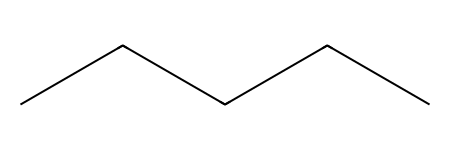

In [17]:
mol

In [4]:
def merge_extracted_ords_mol_names():
    #create one big list of all the pickled names
    folder_path = '/Users/dsw46/Projects/chemical-parameter-sharing/data/USPTO/molecule_names/'
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    full_lst = []
    for file in tqdm(onlyfiles):
        if file[0] != '.': #We don't want to try to unpickle .DS_Store
            filepath = folder_path+file 
            unpickled_lst = pd.read_pickle(filepath)
            full_lst = full_lst + unpickled_lst
            
    return full_lst

In [5]:
names_list = merge_extracted_ords_mol_names()

100%|██████████| 491/491 [00:01<00:00, 470.99it/s] 


In [6]:
len(names_list)

990327

In [9]:
'same catalyst' in names_list

True

In [7]:
# Count the frequency of each item in the list
item_counts = Counter(names_list)

# Sort the items by frequency in descending order
sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted items
for item, count in sorted_items:
    print(f"{item}: {count}")


solution: 74712
ice water: 58770
solid: 38114
ice: 36002
resultant mixture: 21572
aqueous solution: 20788
TEA: 16564
crude product: 15590
hexanes: 14092
oil: 13576
product: 11184
resultant solution: 10184
hydrochloride salt: 6556
compound: 6208
amine: 5652
mixture: 5554
acid chloride: 5260
ester: 4746
alcohol: 4676
hexanes ethyl acetate: 4176
powder: 3488
polyphosphoric acid: 3366
Grignard reagent: 3334
EtOAc hexanes: 3204
petroleum ether: 3064
crude material: 2584
amide: 2542
foam: 2540
methyl ester: 2462
EtOAc-hexanes: 2406
ethyl acetate hexanes: 2400
aldehyde: 2298
4A: 2224
cuprous iodide: 2166
stainless steel: 2046
crystals: 2036
material: 2036
crude mixture: 1896
liquid: 1864
suspension: 1838
catalyst: 1820
three: 1746
anhydride: 1738
title compound: 1692
resultant suspension: 1574
SiO2: 1558
Ice water: 1534
ketone: 1522
N,N-dimethylaminopyridine: 1506
( a ): 1492
dimethyl acetal: 1440
cuprous chloride: 1400
( 1 ): 1398
steel: 1396
residue: 1364
xylenes: 1346
acid: 1316
desired pr

# Verify that all the cat, solv and reagents make sense

In [2]:
import pandas as pd

In [3]:
# read in data
data_df = pd.read_pickle('data/USPTO/clean_test_split_cat.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'data/USPTO/clean_test_split_cat.pkl'

In [ ]:
value_counts = df[columns[0]].value_counts()
        for i in range(1, len(columns)):
            value_counts = value_counts.add(df[columns[i]].value_counts(), fill_value=0)

In [8]:
# Get list of catalysts
catalysts = list(set(list(data_df['catalyst_0'])))
print(len(catalysts))
catalysts

576


['CCCCCC',
 'OC1CCCC1',
 '[Ca+2].[Cl-].[Cl-]',
 'COS(=O)(=O)OC',
 'O=[N+]([O-])[O-].[Ag+]',
 'CC(C)(C)[P]([Pd][P](C(C)(C)C)(C(C)(C)C)C(C)(C)C)(C(C)(C)C)C(C)(C)C',
 'O=[N+]([O-])c1cccc([N+](=O)[O-])c1',
 '[Re]',
 'COc1ccc2c(c1)CN(C)CCn1c-2c(C2CCCCC2)c2ccc(C(=O)O)cc21',
 'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O',
 'NCCN',
 '[Co+2]',
 'Br[Ni]Br',
 'c1cnnnc1',
 'Cc1cc(C)c(N2CCN(c3c(C)cc(C)cc3C)C2=[Ru](Cl)(Cl)(=Cc2ccccc2)[P](C2CCCCC2)(C2CCCCC2)C2CCCCC2)c(C)c1',
 '[60Co]',
 '[N-]=[N+]=[N-].[Na+]',
 'CC(C)=O',
 'CCBr',
 'COCCOCCOCCOCCOCCOCCO',
 'CC(=O)[O-].CC(=O)[O-].[Cu+2]',
 'O=N[O-].[Na+]',
 'ClC(Cl)(Cl)Cl',
 'c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2c(P(c3ccccc3)c3ccccc3)ccc3ccccc23)cc1',
 '[F-].[Na+]',
 'C[P+](c1ccccc1)(c1ccccc1)c1ccccc1.[Br-]',
 'COc1cc(O)ccc1O',
 '[N-]=[N+]=N[Zn]N=[N+]=[N-]',
 'O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21',
 'O=C1CCC(=O)N1Br

In [9]:
# Get list of solvents
solvents = list(set(list(data_df['solvent_0'])+list(data_df['solvent_1'])))
print(len(solvents))
solvents
# O is not a solvent or a catalyst?? Is it a fair reagent to include?? There's also Pd as a solvent lol

96


['C1CCOC1',
 'CCCCCC',
 'O=C([O-])O.[Na+]',
 'COCCO',
 'OCCO',
 'CCNCC',
 'CCOC(=O)CC',
 '[K+].[OH-]',
 'C1CCNCC1',
 'N',
 'O=C([O-])[O-].[Cs+].[Cs+]',
 'c1ccccc1',
 'C1CCOC1.CCO',
 'CC(C)CO',
 'COC(C)(C)C',
 'CN(C)C=O',
 'CC(=O)OC(C)C',
 'CO.O',
 'CC(C)=O',
 'COCCOC',
 'CCO.ClCCl',
 'CCOCCO',
 'O=CO',
 'O',
 'ClC(Cl)(Cl)Cl',
 'COCCOCCOC',
 'CC1CCCO1',
 'c1ccc2ncccc2c1',
 'Cc1ccccc1',
 'CCCCO',
 'CS(C)=O',
 'CC(=O)O',
 'CCC(=O)O',
 'Clc1ccccc1Cl',
 'CCN(CC)CC',
 '[Na+].[OH-]',
 'C1COCCO1',
 'ClCCl.O=C(O)C(F)(F)F',
 'CCC(C)O',
 'OCC(F)(F)F',
 'O=[N+]([O-])c1ccccc1',
 'CCOC(C)=O',
 'CN(C)P(=O)(N(C)C)N(C)C',
 'CCCCCC.CCOC(C)=O',
 'CC(C)(C)O',
 'CCO.CCOC(C)=O',
 'c1ccc(Oc2ccccc2)cc1',
 'Cc1cc(C)nc(C)c1',
 'OCCOCCO',
 'ClCCl',
 'ClC(Cl)Cl',
 '[H][H]',
 'C1CCCCC1',
 'CC(=O)N(C)C',
 'O=S1(=O)CCCC1',
 'CC(=O)CC(C)C',
 'ClCCCl',
 'O=C(O)C(F)(F)F',
 'CCCCCO',
 'CC(Cl)Cl',
 'CO.ClCCl',
 'CCO.O',
 'COc1ccccc1',
 '[O-][Cl+3]([O-])([O-])O',
 'Cc1ccc(C)cc1',
 'Cc1ccccc1C',
 'C1COCCO1.Cl',
 'C[N+](=O)

In [10]:
# Get list of reagents
reagents = list(set(list(data_df['reagent_0'])+list(data_df['reagent_1'])))
print(len(reagents))
reagents

# CCOCC is a solvent???
# There's "C", "N", and "O" as a reagent, this seems wrong

242


['',
 'O=C(OO)c1cccc(Cl)c1',
 'CCOC(OCC)OCC',
 'C1CCOC1',
 'c1ccc(P(c2ccccc2)c2ccccc2)cc1',
 'O=C(OOC(=O)c1ccccc1)c1ccccc1',
 'CCCCCC',
 'O=S([O-])S(=O)[O-]',
 'O=S([O-])[O-]',
 'CN(C)c1ccccc1',
 'CN(C)c1ccncc1',
 'COS(=O)(=O)OC',
 '[BH4-]',
 'CC(C)[O-]',
 'O=[Se]=O',
 'CN(C)C(=N)N(C)C',
 'CCNCC',
 'CC(C)[N-]C(C)C',
 'NCCN',
 'CC(C)(C)O[K]',
 'OO',
 'F[N+]12CC[N+](CCl)(CC1)CC2',
 'Nc1ccc2c(c1)OCCO2',
 'C1CCNCC1',
 'O=C(O)C(=O)O',
 'N',
 '[OH-]',
 'CC(=O)[O-]',
 'CCCCP(CCCC)CCCC',
 '[Li]C(C)(C)C',
 'CN(C)c1ccccn1',
 'c1ccccc1',
 'CC(C)C[Al+]CC(C)C',
 'CCN(CC)c1ccccc1',
 'Cc1ccc(S(=O)(=O)Cl)cc1',
 'CC[Mg]Br',
 'Oc1ccccc1',
 'CS(=O)(=O)Cl',
 'Cc1ccc(S(=O)(=O)O)cc1',
 'CN(C)C=O',
 'CN1CCOCC1',
 'COC(C)(C)C',
 'CC(C)=O',
 'C1=CCCCC1',
 '[Pb]',
 'CCOC(=O)N=NC(=O)OCC',
 'O=C=O',
 'Cc1ccccc1S(=O)(=O)O',
 'CC(C)N=C=NC(C)C',
 'ClCl',
 'C[Si](C)(C)I',
 '[Li]C',
 'O=[Cr](=O)([O-])Cl',
 'CCCC[SnH](CCCC)CCCC',
 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c1',
 '[Cu]I',
 'O=CO',
 'Cl[Sn

# Check out the solvents csv

In [16]:
solvents = pd.read_csv('data/USPTO/solvents.csv', index_col=0)
solvents.loc[375, 'smiles'] = 'ClP(Cl)Cl'
solvents.loc[405, 'smiles'] = 'ClS(Cl)=O'
methanol = {'cosmo_name': 'methanol', 'stenutz_name': 'methanol', 'smiles': 'CO'}
solvents = solvents.append(methanol, ignore_index=True)

/var/folders/hm/0prtzp050kxc67zzx_zttjvh0000gp/T/ipykernel_5589/1334341924.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solvents = solvents.append(methanol, ignore_index=True)


In [17]:
solvents

stenutz_name                 cosmo_name cas_number  \
0       (trichloromethyl)benzene  (trichloromethyl)-benzene    98-07-7   
1    (1Z,5Z)-cycloocta-1,5-diene         1,5-cyclooctadiene   111-78-4   
2          (2E,4E)-2,4-hexadiene  trans,trans-2,4-hexadiene  5194-51-4   
3        (dichloromethyl)benzene   (dichloromethyl)-benzene    98-87-3   
4             (E)-1,3-pentadiene       1-trans-3-pentadiene  2004-70-8   
..                           ...                        ...        ...   
455             triethoxymethane      triethyl orthoformate   122-51-0   
456        N,N-dimethylacetamide      n,n-dimethylacetamide   127-19-5   
457            diisopropyl ether           diisopropylether   108-20-3   
458                   2-propanol                 2-propanol    67-63-0   
459                     methanol                   methanol        NaN   

    chemical_formula  molecular_weight  density  molar_volume  \
0            C7H5Cl3             195.0    1.173         166.6   
1              C8H12             108.0    0.880         122.9   
2              C6H10              82.0    0.727         112.9   
3            C7H6Cl2             161.0    1.250         128.8   
4               C5H8              68.0    0.683          99.7   
..               ...               ...      ...           ...   
455          C7H16O3             148.0    0.893         166.0   
456           C4H9NO              87.0    0.942          92.5   
457           C6H14O             102.0    0.724         141.1   
458            C3H8O              60.0    0.785          76.5   
459              NaN               NaN      NaN           NaN   

     refractive_index  molecular_refractive_power  dielectric_constant  ...  \
0               1.557                       53.67                6.900  ...   
1               1.493                       35.73                2.380  ...   
2               1.456                       30.70                2.220  ...   
3               1.550                       41.04                6.900  ...   
4               1.430                       25.77                2.320  ...   
..                ...                         ...                  ...  ...   
455             1.390                       39.34                4.779  ...   
456             1.438                       24.31               37.780  ...   
457             1.368                       31.80                4.040  ...   
458             1.377                       17.61               19.920  ...   
459               NaN                         NaN                  NaN  ...   

     boiling_point  viscosity  partition_coefficient  vapour_pressure  \
0            220.0       1.85                   3.68             0.20   
1            148.0       1.00                   2.98             8.87   
2             79.0       0.37                   3.05           225.18   
3            205.0       1.99                   2.94             0.24   
4             42.0       0.30                   2.47           702.08   
..             ...        ...                    ...              ...   
455          143.0       1.08                   1.79             0.56   
456          165.0       0.63                  -0.50            10.11   
457           68.0       0.47                   2.51            28.72   
458           82.0       2.40                   0.35            34.41   
459            NaN        NaN                    NaN              NaN   

     sigma_1  sigma_2  sigma_3  sigma_4  sigma_5               smiles  
0     0.2054  18.7984   0.0000  0.00000   3.2973  ClC(Cl)(Cl)c1ccccc1  
1     0.0000  15.2165   0.4711  0.00000   0.9742     C\1C\C=C/CC\C=C1  
2     0.0000  14.9023   0.0451  0.00000   1.3634          C/C=C/C=C/C  
3     0.8684  16.7703   0.0000  0.00810   3.8876      ClC(Cl)c1ccccc1  
4     0.0000  12.8734   0.0397  0.00000   1.8346            C/C=C/C=C  
..       ...      ...      ...      ...      ...                  ...  
455   0.0000  18.630

In [19]:
has_nan_1 = solvents['stenutz_name'].isnull().any()
has_nan_2 = solvents['cosmo_name'].isnull().any()

# Print the result
print(f"The Series has NaN values: {has_nan_1}, {has_nan_2}")

The Series has NaN values: False, False


In [20]:
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol, isomericSmiles=True)

# apply the function to the 'smiles' column of the dataframe
solvents['canonical_smiles'] = solvents['smiles'].apply(canonicalize_smiles)

[19:36:34] WARNING: not removing hydrogen atom without neighbors
[19:36:34] WARNING: not removing hydrogen atom without neighbors
[19:36:34] WARNING: not removing hydrogen atom without neighbors


In [5]:
for i in range(len(solvents)):
    if solvents['smiles'][i] == 'O':
        print(i)

426


In [21]:
## Check how many of the solvents in the data are actually solvents
s = data_df['solvent_0']
my_list = solvents['canonical_smiles']

# Count the number of values in the pd.series that are in my_list
in_list = s.isin(my_list).sum()

# Count the number of values in the pd.series that are not in my_list
not_in_list = (~s.isin(my_list)).sum()

# Count the number of values in the pd.series that are None or NaN
null_values = s.isnull().sum()

print(f"{in_list} values are in the list, {len(s)-in_list-null_values} values are not in the list, and {null_values} values are None or NaN")

338045 values are in the list, 5262 values are not in the list, and 144553 values are None or NaN


In [22]:
not_in_list = s[~s.isin(my_list)]

# Sort the values in descending order of frequency
freq_not_in_list = not_in_list.value_counts()

# # Print the values, starting with the most frequent
for value, count in freq_not_in_list.items():
    print(f"{value}: {count}")

O=S(=O)(O)O: 1171
[Na+].[OH-]: 941
CCCCCC.CCOC(C)=O: 463
ClCCl.O=C(O)C(F)(F)F: 367
O=C([O-])O.[Na+]: 299
N: 256
CCN(C(C)C)C(C)C: 190
CCCCCCC.CCOC(C)=O: 175
[K+].[OH-]: 155
CCO.CCOC(C)=O: 134
O=C([O-])[O-].[Na+].[Na+]: 125
[O-][Cl+3]([O-])([O-])O: 125
CCO.O: 116
C1CCOC1.CCO: 104
CS(=O)(=O)O: 76
O=P([O-])([O-])[O-]: 71
CCCCCO: 66
O=C([O-])[O-].[Cs+].[Cs+]: 64
CC(=O)OC(C)C: 57
OCC(F)(F)F: 55
CCO.ClCCl: 54
C=O: 54
[Pd]: 49
[H][H]: 49
COC(OC)N(C)C: 42
CO.ClCCl: 1
C1COCCO1.Cl: 1
CO.ClC(Cl)Cl: 1
CO.O: 1


In [12]:
my_list

0      ClC(Cl)(Cl)c1ccccc1
1         C1=C\CC/C=C\CC/1
2              C/C=C/C=C/C
3          ClC(Cl)c1ccccc1
4                C=C/C=C/C
              ...         
454            CCCCOC(C)=O
455           CCOC(OCC)OCC
456            CC(=O)N(C)C
457            CC(C)OC(C)C
458                 CC(C)O
Name: canonical_smiles, Length: 459, dtype: object

In [13]:
len(s)

487860

In [15]:
len(s.dropna())

343307

In [117]:
# Inspect pickled data
def merge_extracted_ords():
    #create one big df of all the pickled data
    folder_path = 'data/USPTO/extracted_ords/'
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    full_df = pd.DataFrame()
    for file in tqdm(onlyfiles[:100]):
        if file[0] != '.': #We don't want to try to unpickle .DS_Store
            filepath = folder_path+file 
            unpickled_df = pd.read_pickle(filepath)
            full_df = pd.concat([full_df, unpickled_df], ignore_index=True)
            
    return full_df

In [118]:
df = merge_extracted_ords()

100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


In [120]:
list(df.columns)

['mapped_rxn_0',
 'reactant_0',
 'reactant_1',
 'reactant_2',
 'reactant_3',
 'reactant_4',
 'reactant_5',
 'agent_0',
 'agent_1',
 'agent_2',
 'agent_3',
 'agent_4',
 'agent_5',
 'agent_6',
 'agent_7',
 'agent_8',
 'agent_9',
 'agent_10',
 'agent_11',
 'agent_12',
 'agent_13',
 'agent_14',
 'agent_15',
 'agent_16',
 'agent_17',
 'agent_18',
 'solvent_0',
 'solvent_1',
 'solvent_2',
 'solvent_3',
 'solvent_4',
 'solvent_5',
 'temperature_0',
 'rxn_time_0',
 'product_0',
 'product_1',
 'product_2',
 'product_3',
 'product_4',
 'yield_0',
 'yield_1',
 'yield_2',
 'yield_3',
 'yield_4',
 'agent_19',
 'solvent_6',
 'solvent_7',
 'product_5',
 'yield_5',
 'reactant_6',
 'reactant_7',
 'reactant_8',
 'agent_20',
 'agent_21',
 'solvent_8',
 'solvent_9',
 'solvent_10',
 'solvent_11',
 'agent_22',
 'agent_23',
 'product_6',
 'product_7',
 'yield_6',
 'yield_7',
 'agent_24',
 'agent_25',
 'agent_26',
 'agent_27',
 'agent_28',
 'agent_29',
 'agent_30',
 'agent_31',
 'agent_32',
 'agent_33',
 'age

In [57]:
import pandas as pd

# Example Series and dictionary
reagents = pd.Series(['reagent1', 'reagent2', 'reagent3', 'reagent4'])
replace_dict = {'reagent2': 'a.b', 'reagent4': 'new_reagent4'}

# Apply the dictionary replacement to the Series in-place
reagents.replace(replace_dict, inplace=True)

# Print the resulting Series
print(list(reagents))


['reagent1', 'a.b', 'reagent3', 'new_reagent4']


In [64]:
# Example list of reagents
reagents = ['reagent1', 'a.b', 'reagent3', 'new_reagent4']

# Separate strings with a '.' character into two items and sort alphabetically
reagents_new = [substring for reagent in reagents for substring in reagent.split('.')]

# Print the resulting list
print(reagents_new)



['reagent1', 'a', 'b', 'reagent3', 'new_reagent4']


In [65]:
reag = pd.Series(['reagent1', 'reagent2', 'reagent3', 'reagent4'])
replace_dict = {'reagent2': 'a.b', 'reagent4': 'new_reagent4'}

list((pd.Series(reag)).map(replace_dict))

[nan, 'a.b', nan, 'new_reagent4']

In [43]:
reagents_new

['reagent1', 'a', 'reagent3', 'new_reagent4']

In [68]:
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol)

In [92]:
def build_replacements():
    molecule_replacements = {}
     
    # Add a catalyst to the molecule_replacements dict (Done by Alexander)
    molecule_replacements['CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+3].[Rh+3]'] = 'CC(=O)[O-].[Rh+2]'
    molecule_replacements['[CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+3]]'] = 'CC(=O)[O-].[Rh+2]'
    molecule_replacements['[CC(C)(C)[P]([Pd][P](C(C)(C)C)(C(C)(C)C)C(C)(C)C)(C(C)(C)C)C(C)(C)C]'] = 'CC(C)(C)[PH]([Pd][PH](C(C)(C)C)(C(C)(C)C)C(C)(C)C)(C(C)(C)C)C(C)(C)C'
    molecule_replacements['CCCC[N+](CCCC)(CCCC)CCCC.CCCC[N+](CCCC)(CCCC)CCCC.CCCC[N+](CCCC)(CCCC)CCCC.[Br-].[Br-].[Br-]'] = 'CCCC[N+](CCCC)(CCCC)CCCC.[Br-]'
    molecule_replacements['[CCO.CCO.CCO.CCO.[Ti]]'] = 'CCO[Ti](OCC)(OCC)OCC'
    molecule_replacements['[CC[O-].CC[O-].CC[O-].CC[O-].[Ti+4]]'] = 'CCO[Ti](OCC)(OCC)OCC'
    molecule_replacements['[Cl[Ni]Cl.c1ccc(P(CCCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1]'] = 'Cl[Ni]1(Cl)[P](c2ccccc2)(c2ccccc2)CCC[P]1(c1ccccc1)c1ccccc1'
    molecule_replacements['[Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1]'] = 'Cl[Pd](Cl)([PH](c1ccccc1)(c1ccccc1)c1ccccc1)[PH](c1ccccc1)(c1ccccc1)c1ccccc1'
    molecule_replacements['[Cl[Pd+2](Cl)(Cl)Cl.[Na+].[Na+]]'] = 'Cl[Pd]Cl'
    molecule_replacements['Karstedt catalyst'] =   'C[Si](C)(C=C)O[Si](C)(C)C=C.[Pt]'
    molecule_replacements["Karstedt's catalyst"] = 'C[Si](C)(C=C)O[Si](C)(C)C=C.[Pt]'
    molecule_replacements['[O=C([O-])[O-].[Ag+2]]'] = 'O=C([O-])[O-].[Ag+]'
    molecule_replacements['[O=S(=O)([O-])[O-].[Ag+2]]'] = 'O=S(=O)([O-])[O-].[Ag+]'
    molecule_replacements['[O=[Ag-]]'] = 'O=[Ag]'
    molecule_replacements['[O=[Cu-]]'] = 'O=[Cu]'
    molecule_replacements['[Pd on-carbon]'] = '[C].[Pd]'
    molecule_replacements['[TEA]'] = 'OCCN(CCO)CCO'
    molecule_replacements['[Ti-superoxide]'] = 'O=[O-].[Ti]'
    molecule_replacements['[[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1]'] = '[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['[c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd-4]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['[c1ccc([P]([Pd][P](c2ccccc2)(c2ccccc2)c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['[c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['[sulfated tin oxide]'] = 'O=S(O[Sn])(O[Sn])O[Sn]'
    molecule_replacements['[tereakis(triphenylphosphine)palladium(0)]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['tetrakistriphenylphosphine palladium'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
    molecule_replacements['[zeolite]'] = 'O=[Al]O[Al]=O.O=[Si]=O'
    
    # Molecules found among the most common names in molecule_names
    molecule_replacements['TEA'] = 'OCCN(CCO)CCO'
    molecule_replacements['hexanes'] = 'CCCCCC'
    molecule_replacements['Hexanes'] = 'CCCCCC'
    molecule_replacements['hexanes ethyl acetate'] = 'CCCCCC.CCOC(=O)C'
    molecule_replacements['EtOAc hexanes'] = 'CCCCCC.CCOC(=O)C'
    molecule_replacements['EtOAc-hexanes'] = 'CCCCCC.CCOC(=O)C'
    molecule_replacements['ethyl acetate hexanes'] = 'CCCCCC.CCOC(=O)C'
    molecule_replacements['cuprous iodide'] = '[Cu]I'
    molecule_replacements['N,N-dimethylaminopyridine'] = 'n1ccc(N(C)C)cc1'
    molecule_replacements['dimethyl acetal'] = 'CN(C)C(OC)OC'
    molecule_replacements['cuprous chloride'] = 'Cl[Cu]'
    molecule_replacements["N,N'-carbonyldiimidazole"] = 'O=C(n1cncc1)n2ccnc2'
    # SiO2
    # Went down the list of molecule_names until frequency was 806

    # Iterate over the dictionary and canonicalize each SMILES string
    for key, value in molecule_replacements.items():
        mol = Chem.MolFromSmiles(value)
        
        if mol is not None:
            molecule_replacements[key] = Chem.MolToSmiles(mol)
    return molecule_replacements

In [98]:
molecule_replacements = build_replacements()

[16:24:16] Explicit valence for atom # 1 O, 3, is greater than permitted


In [116]:
values = list(molecule_replacements.values())
values = values[17:18]
for value in values:
    mol = Chem.MolFromSmiles(value)
    print(value)

O=[O-].[Ti]


[16:26:51] Explicit valence for atom # 1 O, 3, is greater than permitted


In [132]:
agents = ['carbon', 'Al' ,'Pd', 'c', 'Al']
metals = [
    'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv'
]
agents = [agent for agent in agents if any(metal in agent for metal in metals)] + [agent for agent in agents if not any(metal in agent for metal in metals)]

In [134]:
agents

['Al', 'Pd', 'Al', 'carbon', 'c']

# Check the overlap between two solvents lists

In [2]:
import pandas as pd

In [11]:
ucb_solvents = pd.read_csv('data/ucb_solvents.csv')
solvents = pd.read_csv('data/solvents.csv')

cas1 = ucb_solvents['cas_number'].tolist()
cas2 = solvents['cas_number'].tolist()

In [21]:
cas1[-1]

'7732-18-5'

In [24]:
count = -1
for cas in cas1:
    count += 1
    if cas not in cas2:
        print(ucb_solvents['solvent_name'][count])

Triflic acid
Lactic Acid
Acetic acid
Methansulfonic acid
1-Methoxypropan-2-ol
Methanol
1-Pentanol
1,3-Propanediol
Xylenes
p-Limonene
Turpentine
p-Cymene
Butylene carbonate
Cyrene
Dimethyl ethylene urea (DMI, DMEU)
2-Ethylhexylacetate
Isopropyl acetate
Glycol diacetate
Dimethyl adipate
γ-Valerolactone (GVL)
Dibutyl succinate
Ethyl Lactate
t-Butyl acetate
Tert-amyl ethyl ether (TAME)
Methyl oleate
Tetramethyl tetrahydrofurane (TMTHF)
1,2,3-trimethoxy propane
Dimethyl isosorbide
Cyclopentyl methyl ether (CPME)
Ethyl tert-butyl ether (ETBE)
Butyl ether
Tetrahydro furfuryl alcohol (THFA)
Furfuryl alcool
PEG-400
PPG-425


In [23]:
solvents.loc[solvents['cas_number'] == '7732-18-5']

Unnamed: 0 stenutz_name cosmo_name cas_number chemical_formula  \
426         426        water        h2o  7732-18-5              H2O   

     molecular_weight  density  molar_volume  refractive_index  \
426                18      1.0          18.0             1.333   

     molecular_refractive_power  ...  boiling_point  viscosity  \
426                        3.71  ...            100        0.9   

     partition_coefficient  vapour_pressure  sigma_1  sigma_2  sigma_3  \
426                  -1.59            31.56   1.6939   1.2049   1.4083   

     sigma_4  sigma_5  smiles  
426   0.8747    1.115       O  

[1 rows x 23 columns]

# Docs

In [ ]:
# USPTO Cleaning docs

    """
After running USPTO_extraction.py, this script will merge and apply further cleaning to the data.

Example: python USPTO_cleaning.py --clean_data_file_name=USPTO_data.csv --consistent_yield=True --num_reactant=1 --num_product=1 --num_solv=1 --num_agent=1 --num_cat=1 --num_reag=1 --min_frequency_of_occurrence=100

    Args:
1) clean_data_file_name, consistent_yield, num_reactant, num_product, num_solv, num_agent, num_cat, num_reag, min_frequency_of_occurrence

    
    
    
    
    
    """

In [ ]:
    """
After running USPTO_extraction.py, this script will merge and apply further cleaning to the data.

    Example: 

python USPTO_cleaning.py --clean_data_file_name=cleaned_USPTO --consistent_yield=True --num_reactant=5 --num_product=5 --num_solv=2 --num_agent=3 --num_cat=0 --num_reag=0 --min_frequency_of_occurrence=100

    Args:
    
1) clean_data_file_name: (str) The filepath where the cleaned data will be saved
2) consistent_yield: (bool) Remove reactions with inconsistent reported yields (e.g. if the sum is under 0% or above 100%. Reactions with nan yields are not removed) 
3) - 8) num_reactant, num_product, num_solv, num_agent, num_cat, num_reag: (int) The number of molecules of that type to keep. Keep in mind that if merge_conditions=True in USPTO_extraction, there will only be agents, but no catalysts/reagents, and if merge_conditions=False, there will only be catalysts and reagents, but no agents. Agents should be seen as a 'parent' category of reagents and catalysts; solvents should fall under this category as well, but since the space of solvents is more well defined (and we have a list of the most industrially relevant solvents which we can refer to), we can separate out the solvents. Therefore, if merge_conditions=True, num_catalyst and num_reagent should be set to 0, and if merge_conditions=False, num_agent should be set to 0. It is recommended to set merge_conditions=True, as we don't believe that the original labelling of catalysts and reagents that reliable; furthermore, what constitutes a catalyst and what constitutes a reagent is not always clear, adding further ambiguity to the labelling, so it's probably best to merge these.
9) min_frequency_of_occurrence: (int) The minimum number of times a molecule must appear in the dataset to be kept. Infrequently occuring molecules will probably add more noise than signal to the dataset, so it is best to remove them.

    Functionality:

1) Merge the pickle files from USPTO_extraction.py into a df
2) Remove reactions with too many reactants, products, sovlents, agents, catalysts, and reagents (num_reactant, num_product, num_solv, num_agent, num_cat, num_reag)
3) Remove reactions with inconsistent yields (consistent_yield)
4) Remove molecules that appear less than min_frequency_of_occurrence times
5) Remove reactions that have a molecule represented by an unresolvable name. This is often an english name or a number.
6) Remove duplicate reactions
7) Pickle the final df

    Output:

1) A pickle file containing the cleaned data
    """

# Inspect rows with weird names

In [24]:
import pickle
import pandas as pd
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

In [5]:
# import cleaned_USPTO.pkl
df = pd.read_pickle('data/USPTO/cleaned_USPTO.pkl')

In [20]:
def merge_extracted_ords():
    #create one big df of all the pickled data
    folder_path = 'data/USPTO/extracted_ords/'
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    full_df = pd.DataFrame()
    for file in tqdm(onlyfiles):
        if file[0] != '.': #We don't want to try to unpickle .DS_Store
            filepath = folder_path+file 
            unpickled_df = pd.read_pickle(filepath)
            full_df = pd.concat([full_df, unpickled_df], ignore_index=True)
            
    return full_df

In [25]:
df = merge_extracted_ords()

100%|██████████| 489/489 [05:56<00:00,  1.37it/s]


In [28]:
smaller_df = df.iloc[:1000].copy()

In [29]:
# Assuming your dataframe is named df
solution_rows = smaller_df[smaller_df.apply(lambda row: row.astype(str).str.contains('solution').any(), axis=1)].head(5)

# Print the first 5 rows that contain 'solution'
solution_rows

mapped_rxn_0  \
21   [Na:1].[CH2:2]1[O:4][CH2:3]1.[C:5]([OH:10])(=[...   
181  [C:1](O)(=O)C.[CH3:5][NH:6][CH3:7].C=O.[CH3:10...   
198  CO[C:3](=[O:16])[C:4]1[C:5](=[CH:10][C:11]([O:...   
246  [CH3:1][C:2]1[C:11]2[C:6](=[CH:7][CH:8]=[CH:9]...   
340  [CH3:1][O:2][C:3]1[CH:8]=[CH:7][CH:6]=[CH:5][C...   

                     reactant_0 reactant_1           reactant_2   reactant_3  \
21                         [Na]      C1CO1         C=C(C)C(=O)O  C=Cc1ccccc1   
181                     CC(=O)O        CNC  COc1ccc2[nH]ccc2c1C         None   
198  COC(=O)c1ccc(OC)cc1C(=O)OC       None                 None         None   
246      Cc1cc(=O)[nH]c2ccccc12   [Li]CCCC                 None         None   
340                 COc1ccccc1O  O=C(Cl)Cl             CN(C)C=O         None   

        reactant_4 reactant_5      agent_0                     agent_1  \
21   C=CC(=O)OCCCC       None         [Na]                C=C(C)C(=O)O   
181           None       None          C=O                         CNC   
198           None       None        [Na+]  COC(=O)c1ccc(OC)cc1C(=O)OC   
246           None       None     [Li]CCCC      Cc1cc(=O)[nH]c2ccccc12   
340           None       None  COc1ccccc1O                   O=C(Cl)Cl   

                 agent_2  ... agent_73 agent_74 agent_75 agent_76 agent_77  \
21         C=CC(=O)OCCCC  ...      NaN      NaN      NaN      NaN      NaN   
181  COc1ccc2[nH]ccc2c1C  ...      NaN      NaN      NaN      NaN      NaN   
198                   Cl  ...      NaN      NaN      NaN      NaN      NaN   
246              hexanes  ...      NaN      NaN      NaN      NaN      NaN   
340             solution  ...      NaN      NaN      NaN      NaN      NaN   

    agent_78 agent_79 agent_80 reactant_9 solvent_12  
21       NaN      NaN      NaN        NaN        NaN  
181      NaN      NaN      NaN        NaN        NaN  
198      NaN      NaN      NaN        NaN        NaN  
246      NaN      NaN      NaN        NaN        NaN  
340      NaN      NaN      NaN        NaN        NaN  

[5 rows x 123 columns]

In [33]:
smaller_df.columns

Index(['mapped_rxn_0', 'reactant_0', 'reactant_1', 'reactant_2', 'reactant_3',
       'reactant_4', 'reactant_5', 'agent_0', 'agent_1', 'agent_2',
       ...
       'agent_73', 'agent_74', 'agent_75', 'agent_76', 'agent_77', 'agent_78',
       'agent_79', 'agent_80', 'reactant_9', 'solvent_12'],
      dtype='object', length=123)

In [38]:
smaller_df.iloc[246].dropna()

mapped_rxn_0    [CH3:1][C:2]1[C:11]2[C:6](=[CH:7][CH:8]=[CH:9]...
reactant_0                                 Cc1cc(=O)[nH]c2ccccc12
reactant_1                                               [Li]CCCC
agent_0                                                  [Li]CCCC
agent_1                                    Cc1cc(=O)[nH]c2ccccc12
agent_2                                                   hexanes
agent_3                                                  solution
solvent_0                                                 C1CCOC1
solvent_1                                                      CI
rxn_time_0                                                    0.5
product_0                                 CCc1cc(=O)[nH]c2ccccc12
Name: 246, dtype: object

In [37]:
smaller_df.iloc[198]['mapped_rxn_0']

'CO[C:3](=[O:16])[C:4]1[C:5](=[CH:10][C:11]([O:14][CH3:15])=[CH:12][CH:13]=1)[C:6]([O:8]C)=[O:7].[OH-].[Na+].Cl>CO>[CH3:15][O:14][C:11]1[CH:10]=[C:5]2[C:4](=[CH:13][CH:12]=1)[C:3](=[O:16])[O:8][C:6]2=[O:7]'

In [61]:
count = -1
for x in df['agent_0']:
    count +=1
    if x != None and len(x) > 0:
        if x.isdigit():
            print(x)
            print(count)
            break

5
74202


In [67]:
df['solvent_2'].dropna()

21                 O
26                 O
32                 O
39                CI
40         ClC(Cl)Cl
             ...    
1771006    Cc1ccccc1
1771010    Cc1ccccc1
1771013    Cc1ccccc1
1771020    Cc1ccccc1
1771028            O
Name: solvent_2, Length: 275513, dtype: object

In [73]:
len(df['agent_3'].dropna())

825264

# Inspect the clean data

In [46]:
import pandas as pd

In [4]:
# import cleaned_USPTO.pkl
df = pd.read_pickle('data/USPTO/cleaned_USPTO.pkl')

In [5]:
len(set(list(df['solvent_0'].dropna())))

159

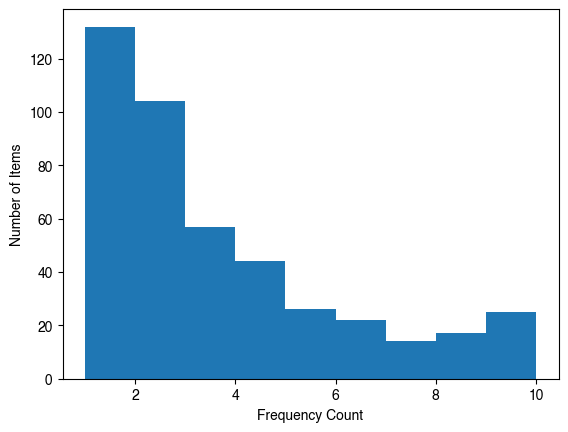

In [6]:
import matplotlib.pyplot as plt

# Count the frequency of each unique value
counts = pd.Series.value_counts(df['agent_0'].dropna())

# Create a list of bins for the histogram
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]

# Plot the histogram
plt.hist(counts, bins=bins)

# Set the x-axis and y-axis labels
plt.xlabel('Frequency Count')
plt.ylabel('Number of Items')

# Show the plot
plt.show()


In [7]:
counts[-100000:]

other                      4082
[Na+]                       453
[K+]                        221
CCN(C(C)C)C(C)C             188
[Pd]                        187
                           ... 
O=C(Cl)c1cccs1                1
OCCBr                         1
O=C(Cl)c1ccc(Cl)c(Cl)c1       1
OCCN1CCNCC1                   1
N#CN                          1
Name: agent_0, Length: 514, dtype: int64

In [8]:
type(counts)

# Count the frequency of each unique value
counts = pd.Series.value_counts(counts)

# Get the count of the value 1
count_of_ones = counts[1]

# Print the count of the value 1
print(count_of_ones)


132


In [9]:
df['temperature_0'].dropna()

5296    1.0
Name: temperature_0, dtype: float64

In [10]:
a,b,c = 1,2,3
assert a<c, b<c: "error"

SyntaxError: invalid syntax (1808044864.py, line 2)